from https://github.com/ritchie46/vanilla-machine-learning

In [1]:
import torch
import torch.distributions as dist
from torch import nn
# from torchvision import datasets, transforms
import torch.nn.functional as F
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
class Planar(nn.Module):
    def __init__(self, size=1, init_sigma=0.01):
        super().__init__()
        self.u = nn.Parameter(torch.randn(1, size).normal_(0, init_sigma))
        self.w = nn.Parameter(torch.randn(1, size).normal_(0, init_sigma))
        self.b = nn.Parameter(torch.zeros(1))

    @property
    def normalized_u(self):
        """
        Needed for invertibility condition.

        See Appendix A.1
        Rezende et al. Variational Inference with Normalizing Flows
        https://arxiv.org/pdf/1505.05770.pdf
        """

        # softplus
        def m(x):
            return -1 + torch.log(1 + torch.exp(x))

        wtu = torch.matmul(self.w, self.u.t())
        w_div_w2 = self.w / torch.norm(self.w)
        return self.u + (m(wtu) - wtu) * w_div_w2

    def psi(self, z):
        """
        ψ(z) =h′(w^tz+b)w

        See eq(11)
        Rezende et al. Variational Inference with Normalizing Flows
        https://arxiv.org/pdf/1505.05770.pdf
        """
        return self.h_prime(z @ self.w.t() + self.b) @ self.w

    def h(self, x):
        return torch.tanh(x)

    def h_prime(self, z):
        return 1 - torch.tanh(z) ** 2

    def forward(self, z):
        if isinstance(z, tuple):
            z, accumulating_ldj = z
        else:
            z, accumulating_ldj = z, 0
        psi = self.psi(z)

        u = self.normalized_u

        # determinant of jacobian
        det = (1 + psi @ u.t())

        # log |det Jac|
        ldj = torch.log(torch.abs(det) + 1e-6)

        wzb = z @ self.w.t() + self.b

        fz = z + (u * self.h(wzb))

        return fz, ldj + accumulating_ldj

In [4]:
class Flow(nn.Module):
    def __init__(self, dim=2, n_flows=10):
        super().__init__()
        self.flow = nn.Sequential(*[
            Planar(dim) for _ in range(n_flows)
        ])
        self.mu = nn.Parameter(torch.randn(dim, ).normal_(0, 0.01))
        self.log_var = nn.Parameter(torch.randn(dim, ).normal_(1, 0.01))

    def forward(self, shape):
        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn(shape)  # unit gaussian
        z0 = self.mu + eps * std

        zk, ldj = self.flow(z0)
        return z0, zk, ldj, self.mu, self.log_var

In [5]:
def det_loss(x, mu, log_var, z_0, z_k, ldj, beta=1.):
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    # batch_size = z_0.size(0)

    # Qz0
    log_qz0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z_0)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk = log_qz0.sum() - ldj.sum()
    
    # P(x|z)
    nll = -dist.Normal(z_k[:, 0], torch.exp(0.5 * z_k[:, 1])).log_prob(x).sum() * beta
    
    return log_qzk + nll  #) #/ batch_size

In [6]:
def train_flow(x, flow, shape, epochs=1000):
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)

    for i in range(epochs):
        z0, zk, ldj, mu, log_var = flow(shape=shape)
        loss = det_loss(x=x,
                        mu=mu,
                        log_var=log_var,
                        z_0=z0,
                        z_k=zk,
                        ldj=ldj,
                        beta=1)
        loss.backward()
        optim.step()
        optim.zero_grad()
        if i % 250 == 0:
            print(loss.item())


In [8]:
x = np.random.normal(loc=5, scale=2, size=1000)

In [9]:
%%time
flow = Flow(dim=2, n_flows=16)
shape = (1, 2)
train_flow(torch.from_numpy(x), flow, shape, epochs=5000)

6622.5339765302
3072.0685454371223
2406.97755157187
2174.8784217689063
2146.4900575906213
2150.093707734993
2142.4957809369357
2151.054184529262
2142.5492682642243
2144.1074275169567
2144.175969248504
2145.472321987992
2148.163513900932
2142.916621652442
2143.931697671088
2143.076770135789
2143.0230753221945
2143.9173072062276
2145.0177323583725
2143.605671794944
CPU times: user 48.7 s, sys: 146 ms, total: 48.9 s
Wall time: 49.3 s


In [86]:
def show_samples(s0, sk, mu):
    
    alpha = 0.2
    
    mask_1 = (z0.data[:, 0] > mu[0]) & (z0.data[:, 1] > mu[1])
    mask_2 = (z0.data[:, 0] > mu[0]) & (z0.data[:, 1] < mu[1])
    mask_3 = (z0.data[:, 0] < mu[0]) & (z0.data[:, 1] > mu[1])
    mask_4 = (z0.data[:, 0] < mu[0]) & (z0.data[:, 1] < mu[1])
    
    for s, title in zip([s0, sk], ['Base distribution $z_0$', '$z_k$']):
        plt.figure(figsize=(8, 8))
        plt.title(title)
        plt.scatter(s[:, 0][mask_1], s[:, 1][mask_1], color='C0', alpha=alpha)
        plt.scatter(s[:, 0][mask_2], s[:, 1][mask_2], color='C1', alpha=alpha)
        plt.scatter(s[:, 0][mask_3], s[:, 1][mask_3], color='C3', alpha=alpha)
        plt.scatter(s[:, 0][mask_4], s[:, 1][mask_4], color='C4', alpha=alpha)
        
        plt.xlim(-7.5, 7.5)
        plt.ylim(-7.5, 7.5)
        
        # Plot truth
        plt.scatter(5, np.log(2**2), color='black', alpha=1)
        
        plt.show()

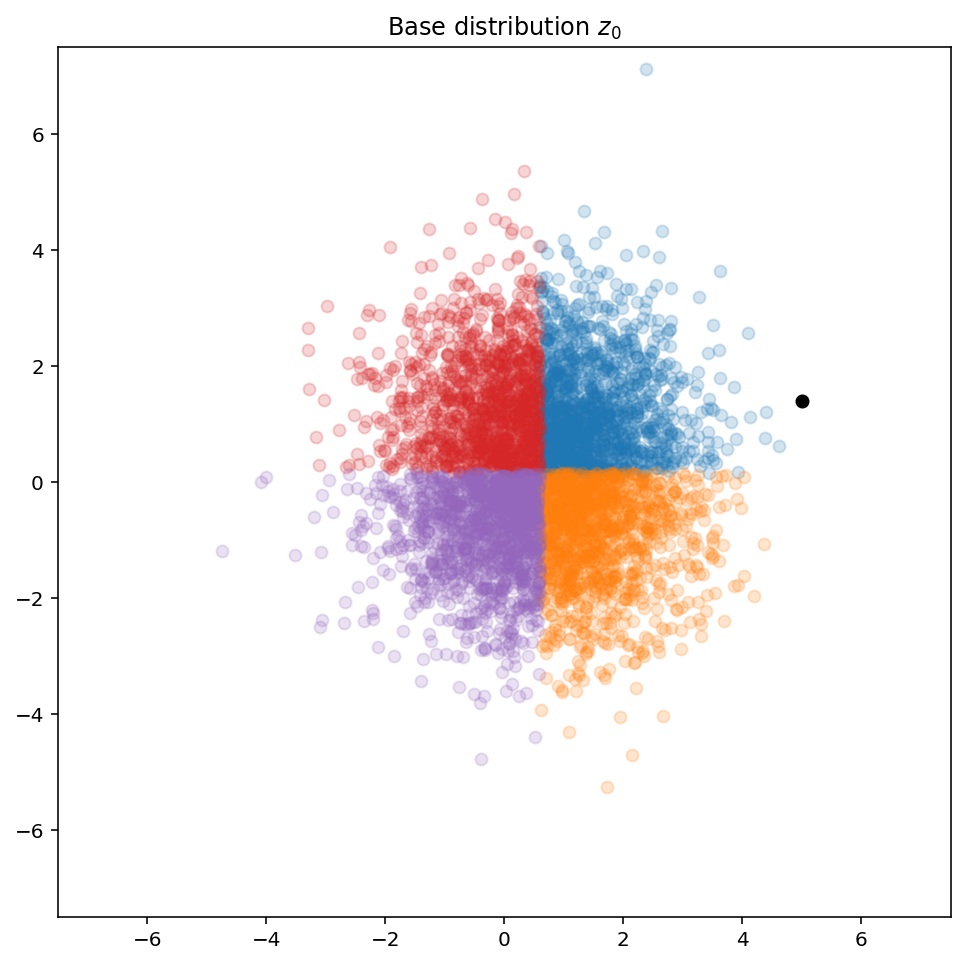

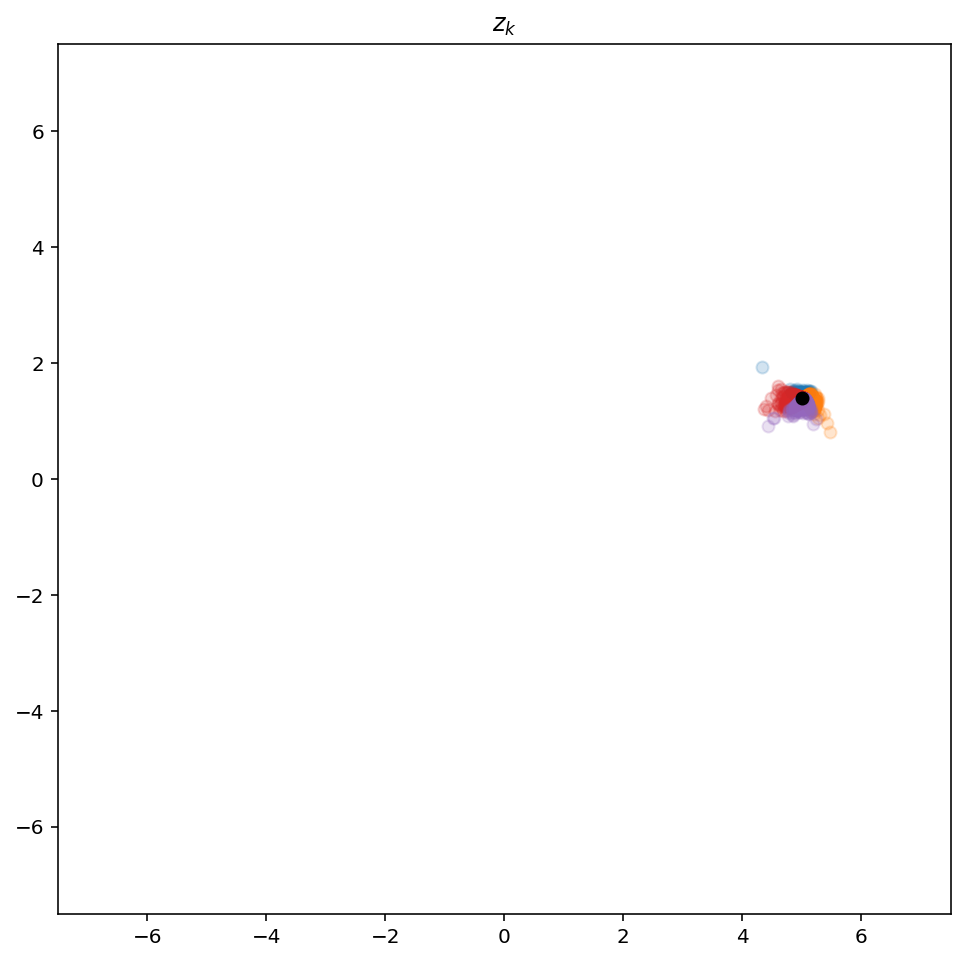

In [87]:
z0, zk, ldj, mu, log_var = flow((5000, 2))
show_samples(z0.data, zk.data, mu)

In [80]:
zk_mu = np.array(zk.data[:, 0])
zk_std = np.array(zk.data[:, 1])

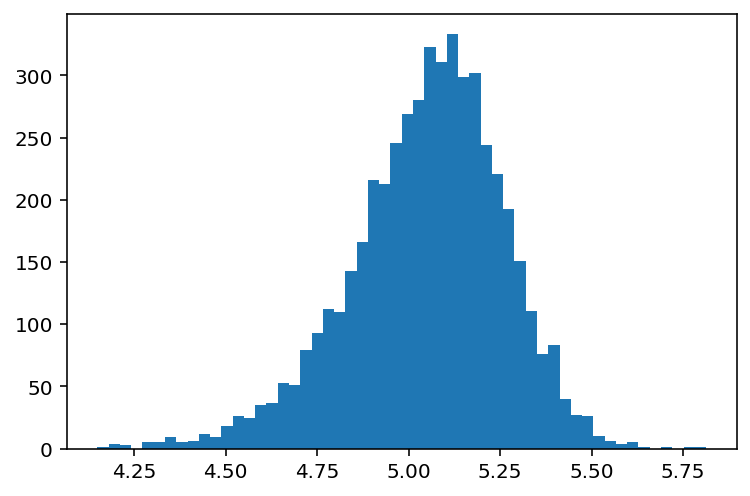

In [70]:
plt.hist(zk_mu, bins='auto');

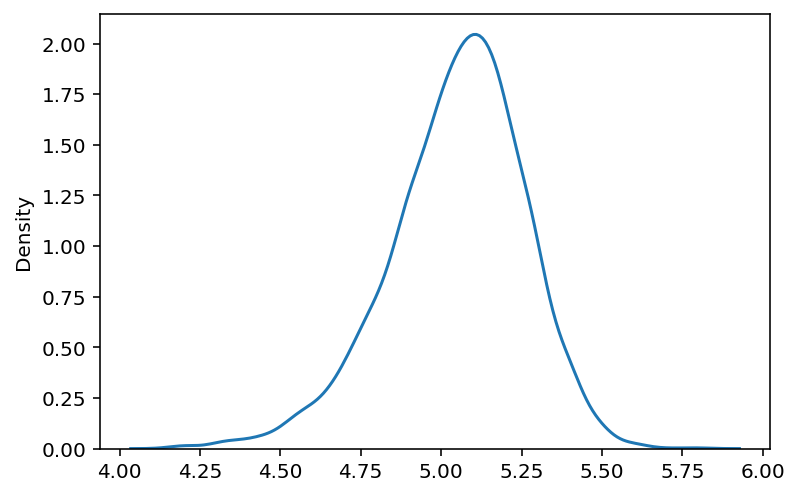

In [71]:
sns.kdeplot(zk_mu);

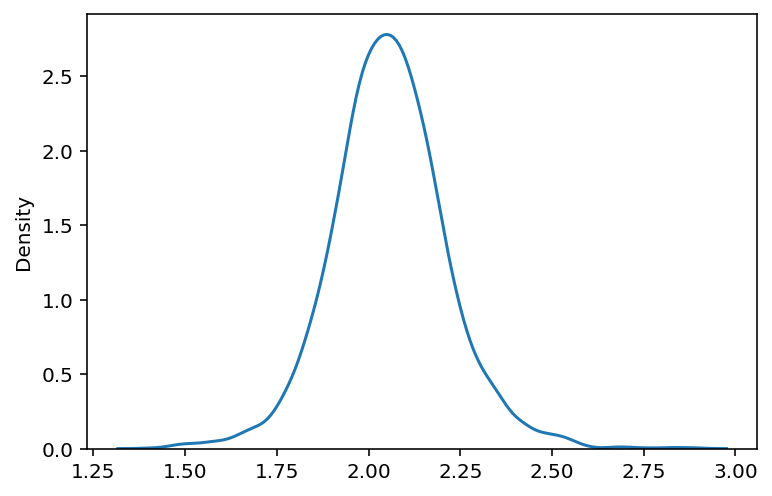

In [74]:
sns.kdeplot(np.exp(0.5*zk_std));